# MFCCs: Complete Guide with Intuitive Explanations

## Introduction

**MFCCs (Mel-Frequency Cepstral Coefficients)** are the most important audio features for:

- Speech Recognition
- Speaker Identification
- Music Genre Classification
- Instrument Recognition

This notebook covers:
1. Intuitive explanations (simple analogies)
2. Technical depth (mathematics)
3. Visual understanding (diagrams)
4. Practical implementation (Python)
5. Real-world applications

## Prerequisites

- Notebook 11: FFT Parameters
- Notebook 12: Mel Spectrograms

## Learning Path

```
Notebook 11: FFT Parameters
    ↓
Notebook 12: Mel Spectrograms
    ↓
Notebook 13: MFCCs (THIS ONE)
    ↓
Ready for Machine Learning!
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
from scipy.fftpack import dct
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print('Libraries loaded successfully!')

Libraries loaded successfully!


---

# Part 1: MFCC Intuition

## The Restaurant Analogy

Imagine describing a restaurant:

**Bad (Raw Audio):** The waiter said Welcome at 440 Hz, then Please sit at 523 Hz...
- Too much detail!

**Better (Spectrogram):** They play jazz music, people talk at various pitches...
- Still too much information!

**Best (MFCCs):** Cozy atmosphere, warm lighting, soft jazz ambiance
- This is the ESSENCE - the TIMBRE!

**MFCCs capture the essence of sound, not the details!**

## The Photo Compression Analogy

Think of MFCCs like JPEG compression:

**Original (Spectrogram):**
- 1,000,000 pixels
- Every detail
- 5 MB

**Compressed (MFCCs):**
- 10,000 numbers
- Keeps what matters
- 100 KB

**MFCCs do the same for audio:**
- Keep: Spectral envelope (timbre)
- Discard: Fine details (pitch)

## The Shape of Sound

Imagine sound as a mountain:

**Spectrogram:** Shows every rock, tree, detail (jagged)

**MFCCs:** Shows overall mountain shape (smooth envelope)

The smooth curve is what MFCCs capture!

## Why We Need MFCCs

### Problem 1: Too Much Data
- Spectrogram: 1025 bins × 100 frames = 102,500 numbers
- MFCCs: 13 coeffs × 100 frames = 1,300 numbers
- 87% reduction!

### Problem 2: Irrelevant Information
- Example: Piano vs Guitar playing same note A (440 Hz)
- Same pitch (don't want)
- Different timbre (want!)
- MFCCs capture only the timbre difference

### Problem 3: Correlated Features
- Spectrogram: Adjacent bins are correlated (bad for ML)
- MFCCs: Decorrelated (good for ML)

**MFCCs solve all three problems!**

In [2]:
# Demonstrate data reduction
sr = 22050
duration = 1.0
t = np.linspace(0, duration, int(sr * duration))
test_signal = signal.chirp(t, 200, duration, 2000, method='linear')

n_fft = 2048
hop_length = 512

D = librosa.stft(test_signal, n_fft=n_fft, hop_length=hop_length)
mfccs = librosa.feature.mfcc(y=test_signal, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)

spec_size = D.shape[0] * D.shape[1]
mfcc_size = mfccs.shape[0] * mfccs.shape[1]
reduction = (1 - mfcc_size / spec_size) * 100

print('='*70)
print('DATA REDUCTION COMPARISON')
print('='*70)
print(f'Spectrogram: {D.shape} = {spec_size:,} numbers')
print(f'MFCCs: {mfccs.shape} = {mfcc_size:,} numbers')
print(f'Reduction: {reduction:.1f}%')
print(f'Compression: {spec_size/mfcc_size:.1f}x')
print('='*70)

DATA REDUCTION COMPARISON
Spectrogram: (1025, 44) = 45,100 numbers
MFCCs: (13, 44) = 572 numbers
Reduction: 98.7%
Compression: 78.8x


---

# Part 2: DCT Intuition

## What is DCT?

**DCT = Discrete Cosine Transform**

Think of it as a **sorting machine** that organizes by how fast things change:

**Input:** Wiggly line (log-Mel spectrum)

**Output:** Numbers sorted by wiggliness
- First numbers: Slow changes (overall shape) - KEEP
- Last numbers: Fast changes (tiny details) - DISCARD

## The Music Equalizer Analogy

**Music Equalizer** sorts by frequency:
- Bass (low frequencies)
- Mid (middle frequencies)
- Treble (high frequencies)

**DCT** sorts by change speed:
- Coeff 0: Overall level (DC)
- Coeff 1-5: Slow changes (broad shape) - KEEP
- Coeff 6-12: Medium changes (details) - KEEP
- Coeff 13+: Fast changes (noise) - DISCARD

We keep the first 13 because they describe the shape!

## The Lego Blocks Analogy

**Big Blocks (Low DCT Coefficients):**
- Build overall shape
- This is a house
- KEEP!

**Small Blocks (High DCT Coefficients):**
- Add tiny details
- This brick has a scratch
- DISCARD!

**Key Insight:**
- Low coefficients = Big blocks = Shape = TIMBRE
- High coefficients = Small blocks = Details = NOISE

## DCT vs FFT

**FFT:**
- Separates by frequency
- Time domain to frequency domain
- Produces complex numbers
- Used in spectrograms

**DCT:**
- Separates by rate of change
- Spectrum to cepstrum
- Produces real numbers only
- Used in MFCCs

## Why DCT Instead of FFT?

1. **Real numbers only** (simpler)
2. **Better energy compaction** (more efficient)
3. **No redundancy** (no negative frequencies)

## The Smoothing Intuition

DCT decomposes wiggly line into components:
- Coeff 0: Flat (average)
- Coeff 1: Slow rise
- Coeff 2: Gentle curve
- Coeff 3: Two bumps
- ...
- Coeff 12: Medium wiggle

We keep 0-12 because they describe the smooth envelope!

## DCT Basis Functions

DCT uses cosine waves:
- Coefficient 0: Flat (DC/average)
- Coefficient 1: Slow rise (one bump)
- Coefficient 2: One bump
- Coefficient 3: Two bumps
- ...
- Coefficient 12: Many bumps

**Pattern:**
- Lower coefficients = Fewer bumps = Smoother = SHAPE
- Higher coefficients = More bumps = Noisier = DETAILS

This is why we keep only the first 13 coefficients!

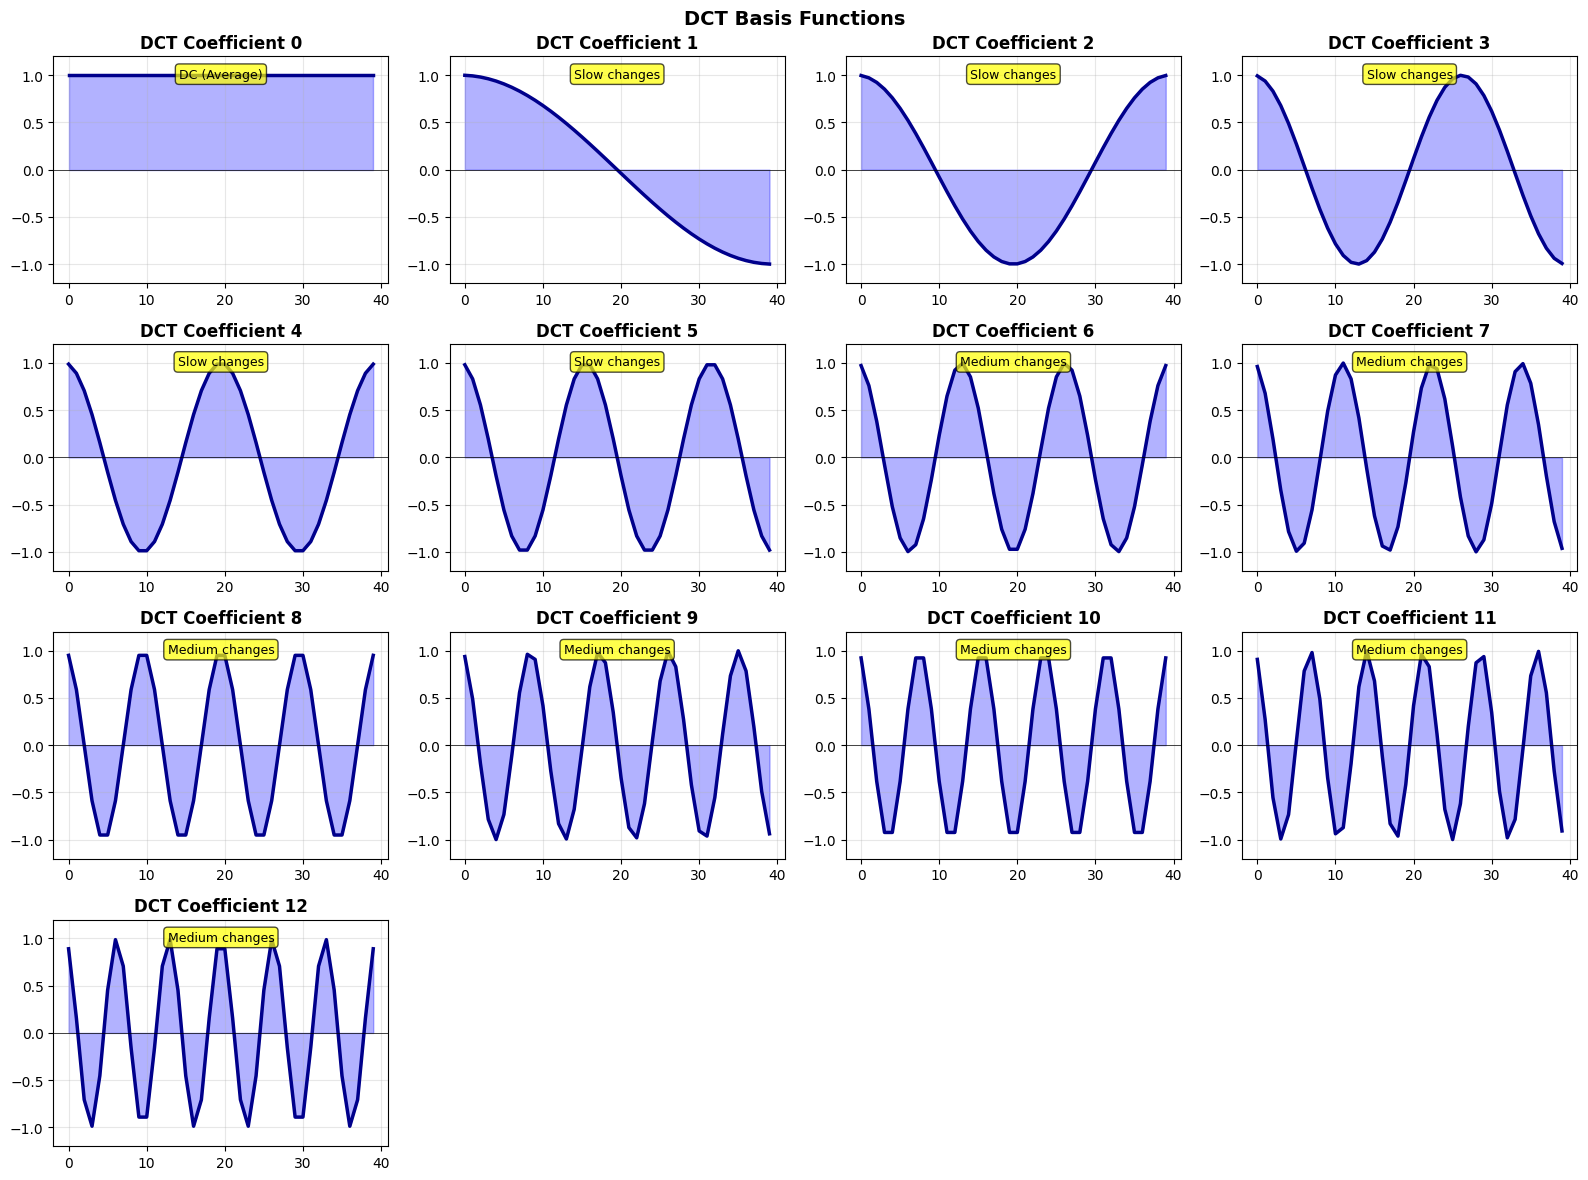

Key Observations:
  - Coefficient 0: Flat (DC = average energy)
  - Coefficients 1-5: Few bumps (slow changes)
  - Coefficients 6-12: More bumps (medium changes)
  - Coefficients 13+: Many bumps (fast changes = noise)


In [3]:
# Visualize DCT basis functions
n_coeffs = 13
n_points = 40

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i in range(min(n_coeffs, 16)):
    basis = np.cos(np.pi * i * (np.arange(n_points) + 0.5) / n_points)
    
    axes[i].plot(basis, linewidth=2.5, color='darkblue')
    axes[i].fill_between(range(n_points), 0, basis, alpha=0.3, color='blue')
    axes[i].set_title(f'DCT Coefficient {i}', fontweight='bold')
    axes[i].set_ylim([-1.2, 1.2])
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    
    if i == 0:
        label = 'DC (Average)'
    elif i <= 5:
        label = 'Slow changes'
    elif i <= 12:
        label = 'Medium changes'
    else:
        label = 'Fast changes'
    
    axes[i].text(0.5, 0.95, label, transform=axes[i].transAxes,
                ha='center', va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

for i in range(n_coeffs, 16):
    axes[i].axis('off')

plt.suptitle('DCT Basis Functions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('Key Observations:')
print('  - Coefficient 0: Flat (DC = average energy)')
print('  - Coefficients 1-5: Few bumps (slow changes)')
print('  - Coefficients 6-12: More bumps (medium changes)')
print('  - Coefficients 13+: Many bumps (fast changes = noise)')

## The Complete Picture

**Step-by-Step:**

1. **Mel Spectrum:** Energy at different frequencies (correlated)
2. **Log Transform:** Perceptual (humans hear logarithmically)
3. **DCT (THE MAGIC!):** Reorganizes information
   - Separates smooth changes from fast changes
   - Decorrelates features
   - Lower coefficients = Spectral envelope = TIMBRE
   - Higher coefficients = Fine details = PITCH/NOISE
4. **Keep Low Coefficients:** Keep 0-12 (shape), discard 13+ (noise)

**Result: 13 numbers that capture the tone color of sound!**

**Why Cepstrum?**
- Spectrum reversed = Cepstrum (first 4 letters)
- Spectrum of a spectrum
- Playful name for powerful concept

---

# Part 3: Source-Filter Model

## Understanding Sound Production

All sounds: **Sound = Source × Filter**

### The Source (Excitation)
- Initial vibration
- Examples: Vocal cords, guitar string, trumpet lips
- Determines: **PITCH** (fundamental frequency)

### The Filter (Resonator)
- Body that shapes sound
- Examples: Vocal tract, guitar body, trumpet tube
- Determines: **TIMBRE** (tone color)

## Why This Matters

### For Speech Recognition
- Care about: WHAT is said (filter/timbre)
- Don't care about: WHO said it (pitch)
- Example: Hello by man vs woman
  - Different pitch (source)
  - Same phoneme (filter) - THIS IS WHAT WE WANT!

### For Instrument Classification
- Care about: WHICH instrument (timbre)
- Don't care about: WHICH note (pitch)
- Example: Note A on piano vs guitar
  - Same pitch (440 Hz)
  - Different timbre - THIS IS WHAT WE WANT!

**MFCCs separate filter from source, keeping only timbre!**

---

# Part 4: The Complete MFCC Pipeline

## 8 Steps to MFCCs

```
Audio Signal
    ↓
1. Framing (20-40ms windows)
    ↓
2. Windowing (Hanning/Hamming)
    ↓
3. FFT (STFT)
    ↓
4. Mel Filterbank (20-40 filters)
    ↓
5. Log Transform (decibels)
    ↓
6. DCT (THE KEY STEP)
    ↓
7. Keep Lower Coefficients (0-12)
    ↓
MFCCs (13 coefficients)
```

## Step Details

**Step 1: Framing**
- Why: Audio is non-stationary
- How: Split into 20-40ms frames with overlap

**Step 2: Windowing**
- Why: Reduce spectral leakage
- How: Apply Hanning/Hamming window

**Step 3: FFT**
- Why: Convert to frequency domain
- How: Apply FFT to each frame

**Step 4: Mel Filterbank**
- Why: Match human hearing (logarithmic)
- How: Apply 20-40 triangular filters on Mel scale

**Step 5: Log Transform**
- Why: Match loudness perception
- How: Convert to decibels

**Step 6: DCT (KEY STEP)**
- Why: Decorrelate, separate envelope from details
- How: Apply DCT to log-Mel spectrum

**Step 7: Keep Coefficients**
- Why: Lower coeffs = timbre, higher = noise
- How: Keep first 13 coefficients

**Final Output: 13 MFCCs per frame**

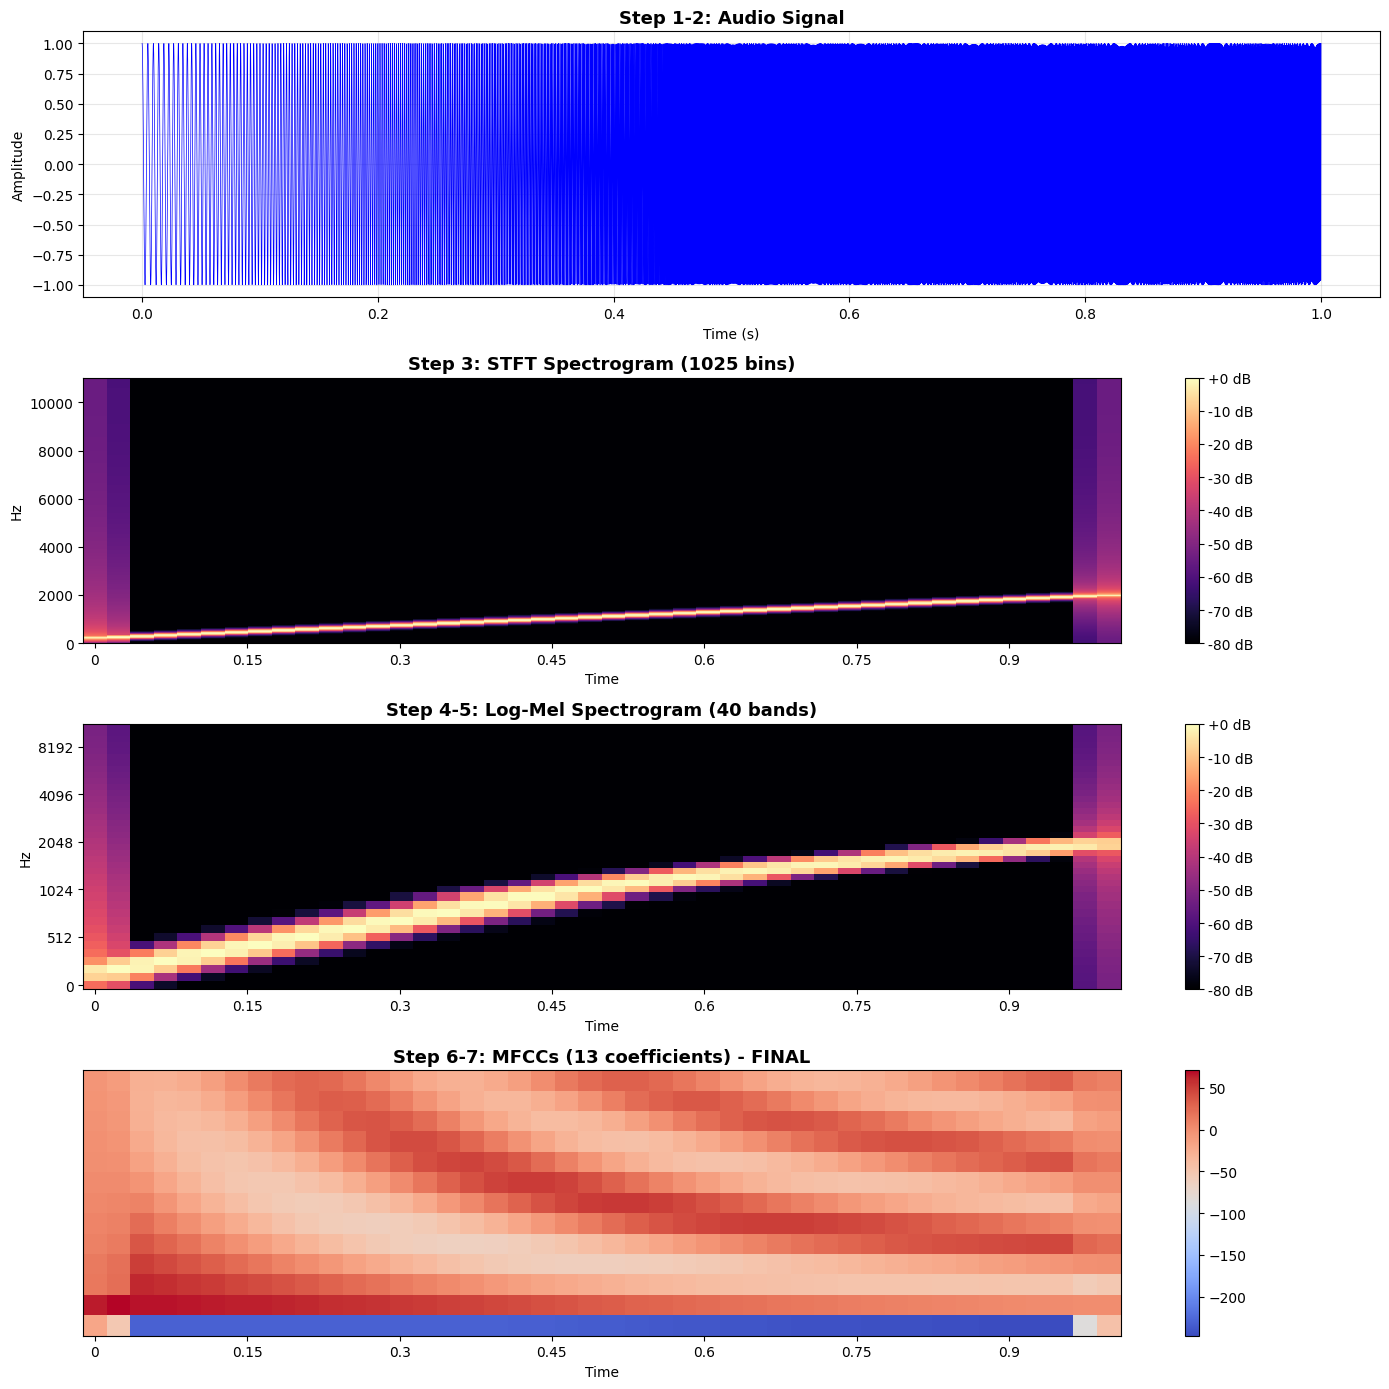

Pipeline Summary:
  Input: 22,050 samples
  STFT: 1025 x 44 = 45,100 numbers
  Mel: 40 x 44 = 1,760 numbers
  MFCCs: 13 x 44 = 572 numbers
  Reduction: 98.7%


In [4]:
# Complete pipeline visualization
sr = 22050
duration = 1.0
t = np.linspace(0, duration, int(sr * duration))
test_signal = signal.chirp(t, 200, duration, 2000, method='linear')

n_fft = 2048
hop_length = 512
n_mels = 40
n_mfcc = 13

# Compute all stages
D = librosa.stft(test_signal, n_fft=n_fft, hop_length=hop_length)
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

mel_spec = librosa.feature.melspectrogram(y=test_signal, sr=sr, n_fft=n_fft, 
                                          hop_length=hop_length, n_mels=n_mels)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

mfccs = librosa.feature.mfcc(y=test_signal, sr=sr, n_mfcc=n_mfcc, 
                             n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

# Visualize
fig, axes = plt.subplots(4, 1, figsize=(14, 14))

# Waveform
axes[0].plot(t, test_signal, 'b-', linewidth=0.5)
axes[0].set_title('Step 1-2: Audio Signal', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

# Spectrogram
librosa.display.specshow(D_db, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='hz', cmap='magma', ax=axes[1])
axes[1].set_title(f'Step 3: STFT Spectrogram ({D.shape[0]} bins)', fontsize=13, fontweight='bold')
plt.colorbar(librosa.display.specshow(D_db, sr=sr, hop_length=hop_length,
                                      x_axis='time', y_axis='hz', cmap='magma', ax=axes[1]),
            ax=axes[1], format='%+2.0f dB')

# Mel Spectrogram
librosa.display.specshow(log_mel_spec, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='mel', cmap='magma', ax=axes[2])
axes[2].set_title(f'Step 4-5: Log-Mel Spectrogram ({n_mels} bands)', fontsize=13, fontweight='bold')
plt.colorbar(librosa.display.specshow(log_mel_spec, sr=sr, hop_length=hop_length,
                                      x_axis='time', y_axis='mel', cmap='magma', ax=axes[2]),
            ax=axes[2], format='%+2.0f dB')

# MFCCs
librosa.display.specshow(mfccs, sr=sr, hop_length=hop_length,
                         x_axis='time', cmap='coolwarm', ax=axes[3])
axes[3].set_title(f'Step 6-7: MFCCs ({n_mfcc} coefficients) - FINAL', fontsize=13, fontweight='bold')
axes[3].set_ylabel('MFCC Coefficient')
plt.colorbar(librosa.display.specshow(mfccs, sr=sr, hop_length=hop_length,
                                      x_axis='time', cmap='coolwarm', ax=axes[3]),
            ax=axes[3])

plt.tight_layout()
plt.show()

print('Pipeline Summary:')
print(f'  Input: {len(test_signal):,} samples')
print(f'  STFT: {D.shape[0]} x {D.shape[1]} = {D.shape[0]*D.shape[1]:,} numbers')
print(f'  Mel: {n_mels} x {mel_spec.shape[1]} = {n_mels*mel_spec.shape[1]:,} numbers')
print(f'  MFCCs: {n_mfcc} x {mfccs.shape[1]} = {n_mfcc*mfccs.shape[1]:,} numbers')
print(f'  Reduction: {(1-(n_mfcc*mfccs.shape[1])/(D.shape[0]*D.shape[1]))*100:.1f}%')

---

# Part 5: Practical Implementation

## Using Librosa (Simple)

In [5]:
# Simple MFCC extraction
sr = 22050
duration = 1.0
t = np.linspace(0, duration, int(sr * duration))
test_audio = signal.chirp(t, 200, duration, 2000, method='linear')

# Extract MFCCs (one line!)
mfccs = librosa.feature.mfcc(y=test_audio, sr=sr, n_mfcc=13)

print(f'MFCC Shape: {mfccs.shape}')
print(f'  - {mfccs.shape[0]} coefficients')
print(f'  - {mfccs.shape[1]} time frames')
print(f'\nFirst frame MFCCs:')
for i, coeff in enumerate(mfccs[:, 0]):
    print(f'  MFCC[{i}] = {coeff:8.3f}')

MFCC Shape: (13, 44)
  - 13 coefficients
  - 44 time frames

First frame MFCCs:
  MFCC[0] =  -38.188
  MFCC[1] =  110.269
  MFCC[2] =   22.271
  MFCC[3] =   20.732
  MFCC[4] =   10.687
  MFCC[5] =    6.636
  MFCC[6] =    1.345
  MFCC[7] =   -2.062
  MFCC[8] =   -5.419
  MFCC[9] =   -7.723
  MFCC[10] =   -9.774
  MFCC[11] =  -11.164
  MFCC[12] =  -12.287


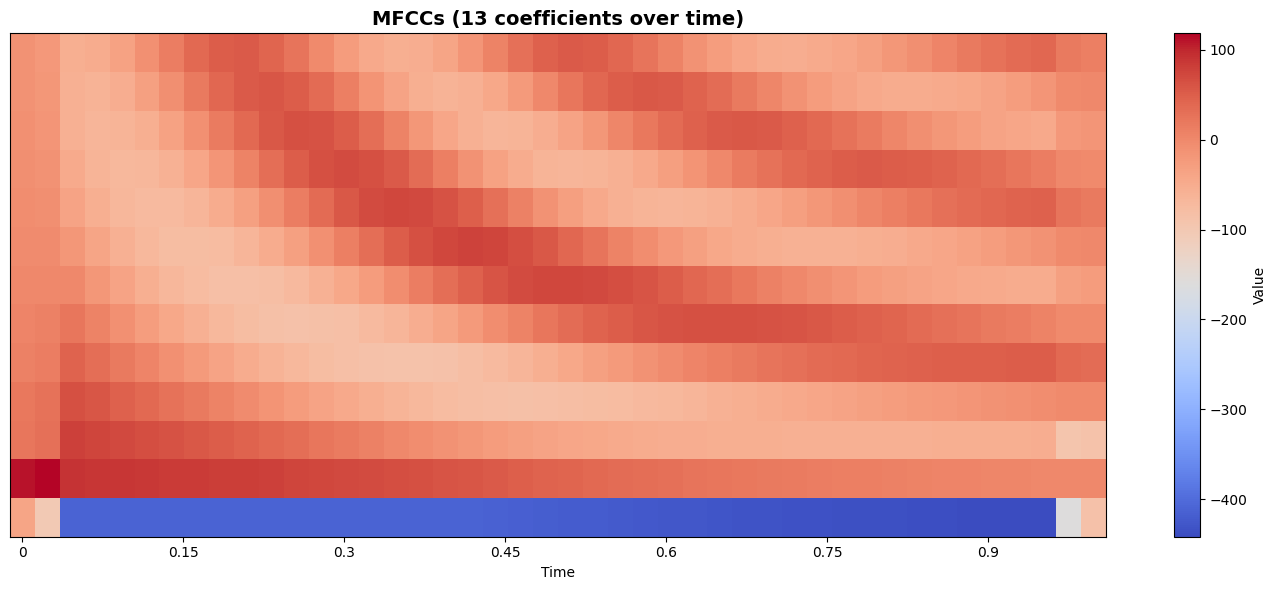

In [6]:
# Visualize MFCCs
fig, ax = plt.subplots(figsize=(14, 6))

librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='coolwarm', ax=ax)
ax.set_title('MFCCs (13 coefficients over time)', fontsize=14, fontweight='bold')
ax.set_ylabel('MFCC Coefficient')
plt.colorbar(librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='coolwarm', ax=ax),
            ax=ax, label='Value')

plt.tight_layout()
plt.show()

---

# Part 6: Delta and Delta-Delta MFCCs

## Why Static Features Aren't Enough

MFCCs alone (static features) only describe spectral envelope for single frame.

They don't capture how sound changes over time!

## Solution: Add Derivatives

**Deltas (First Derivative):**
- Represent velocity of MFCCs
- How fast they are changing

**Delta-Deltas (Second Derivative):**
- Represent acceleration of MFCCs
- Rate of velocity change

## Why They Matter

In speech, transitions between sounds are often more important than static sounds!

Example: Moving from vowel to consonant

## Implementation

In [7]:
# Extract MFCCs and derivatives
mfccs = librosa.feature.mfcc(y=test_audio, sr=sr, n_mfcc=13)

# Compute deltas
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

print('Feature Shapes:')
print(f'  MFCCs: {mfccs.shape}')
print(f'  Delta MFCCs: {delta_mfccs.shape}')
print(f'  Delta-Delta MFCCs: {delta2_mfccs.shape}')

# Concatenate for ML
comprehensive_mfccs = np.vstack([mfccs, delta_mfccs, delta2_mfccs])
print(f'\nComprehensive features: {comprehensive_mfccs.shape}')
print(f'  13 MFCCs + 13 Deltas + 13 Delta-Deltas = 39 features per frame')

Feature Shapes:
  MFCCs: (13, 44)
  Delta MFCCs: (13, 44)
  Delta-Delta MFCCs: (13, 44)

Comprehensive features: (39, 44)
  13 MFCCs + 13 Deltas + 13 Delta-Deltas = 39 features per frame


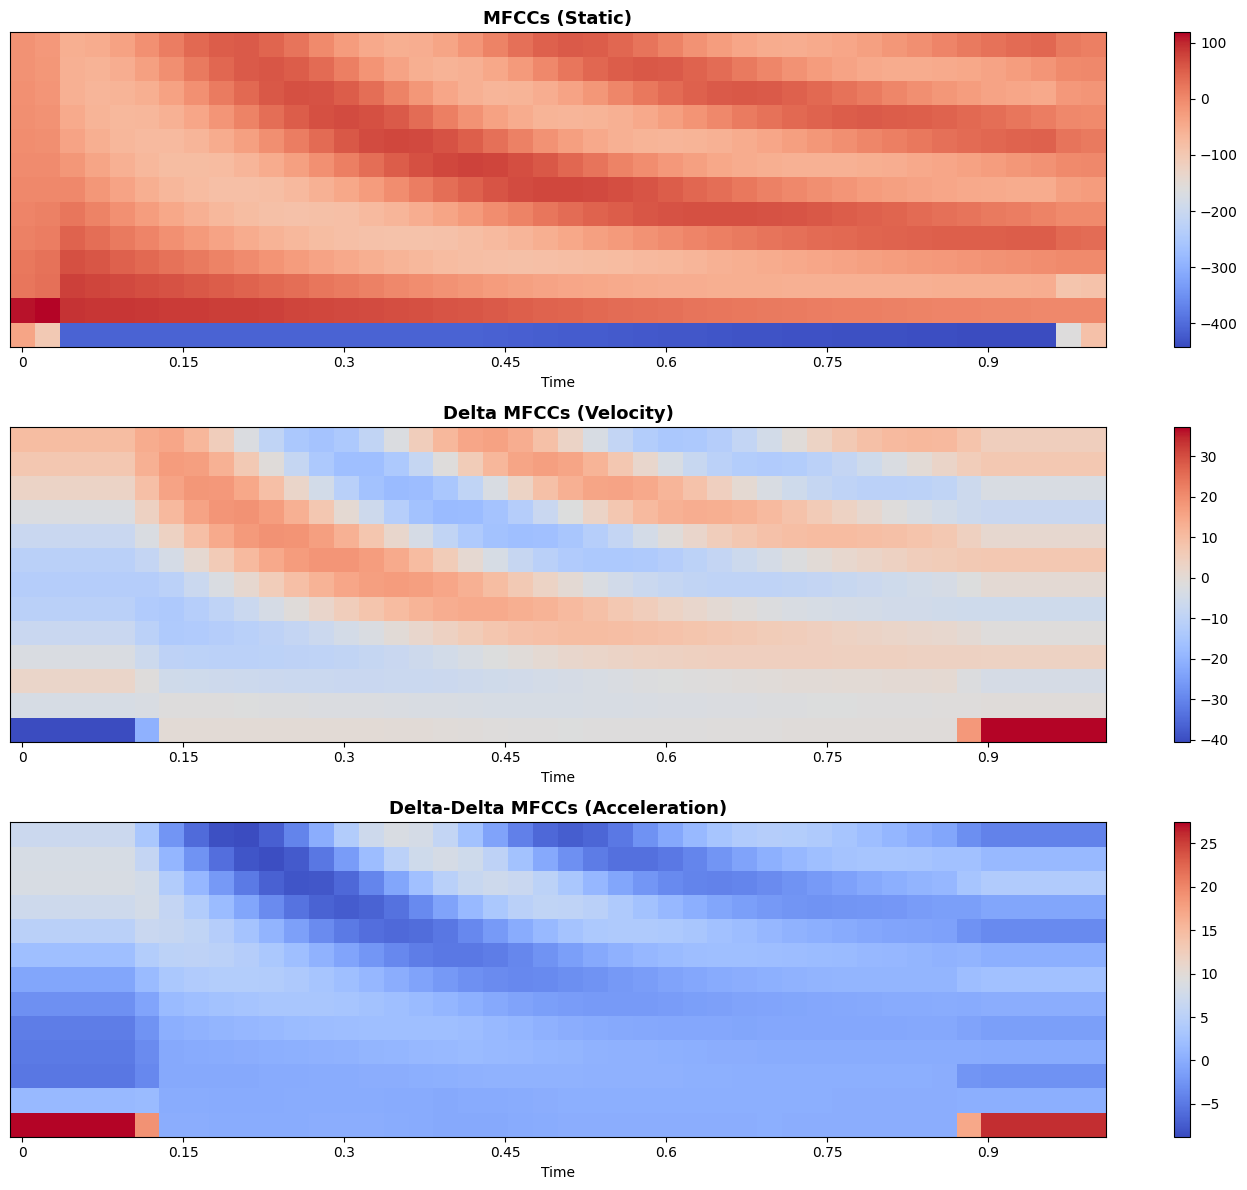

In [8]:
# Visualize all three
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='coolwarm', ax=axes[0])
axes[0].set_title('MFCCs (Static)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Coefficient')
plt.colorbar(librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='coolwarm', ax=axes[0]),
            ax=axes[0])

librosa.display.specshow(delta_mfccs, sr=sr, x_axis='time', cmap='coolwarm', ax=axes[1])
axes[1].set_title('Delta MFCCs (Velocity)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Coefficient')
plt.colorbar(librosa.display.specshow(delta_mfccs, sr=sr, x_axis='time', cmap='coolwarm', ax=axes[1]),
            ax=axes[1])

librosa.display.specshow(delta2_mfccs, sr=sr, x_axis='time', cmap='coolwarm', ax=axes[2])
axes[2].set_title('Delta-Delta MFCCs (Acceleration)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Coefficient')
plt.colorbar(librosa.display.specshow(delta2_mfccs, sr=sr, x_axis='time', cmap='coolwarm', ax=axes[2]),
            ax=axes[2])

plt.tight_layout()
plt.show()

---

# Part 7: Complete ML Pipeline

## End-to-End Example

In [9]:
# Complete feature extraction pipeline
def extract_features(audio, sr, n_mfcc=13):
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # Extract deltas
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # Stack features (13 + 13 + 13 = 39)
    features = np.vstack([mfccs, delta_mfccs, delta2_mfccs])
    
    # Aggregate over time (mean and std)
    feature_vector = np.hstack([
        np.mean(features, axis=1),
        np.std(features, axis=1)
    ])  # Shape: (78,)
    
    return feature_vector

# Example usage
features = extract_features(test_audio, sr)
print(f'Feature vector shape: {features.shape}')
print(f'  39 features x 2 (mean + std) = 78 dimensions')
print(f'\nReady for machine learning!')

Feature vector shape: (78,)
  39 features x 2 (mean + std) = 78 dimensions

Ready for machine learning!


---

# Summary

## Key Takeaways

### 1. MFCC Intuition
- MFCCs capture essence of sound (timbre), not details (pitch)
- Like JPEG compression for audio
- 87% data reduction while preserving important information

### 2. DCT Magic
- Sorting machine for change speed
- Lower coefficients = smooth envelope = timbre
- Higher coefficients = fast changes = noise
- Keep first 13 coefficients

### 3. Source-Filter Model
- Source = pitch (vocal cords, strings)
- Filter = timbre (vocal tract, instrument body)
- MFCCs capture filter, discard source

### 4. Complete Pipeline
1. Framing
2. Windowing
3. FFT
4. Mel Filterbank
5. Log Transform
6. DCT (KEY STEP)
7. Keep Lower Coefficients

### 5. Temporal Dynamics
- Static MFCCs: 13 coefficients
- Delta MFCCs: 13 coefficients (velocity)
- Delta-Delta MFCCs: 13 coefficients (acceleration)
- Total: 39 features per frame

## When to Use MFCCs

**Use MFCCs for:**
- Speech recognition
- Speaker identification
- Music genre classification
- Instrument recognition
- Classical ML algorithms (SVM, GMM)

**Don't use MFCCs for:**
- Pitch detection (use other features)
- When you need full spectral detail

## The Big Picture

```
Audio Signal
    ↓
STFT (Notebook 11)
    ↓
Mel Spectrogram (Notebook 12)
    ↓
MFCCs (Notebook 13)
    ↓
Machine Learning Model
```

## Final Thoughts

**MFCCs in one sentence:**
13 numbers that describe the tone color of a sound, ignoring the pitch.

**DCT in one sentence:**
A sorting machine that organizes spectrum by change speed, keeping smooth shape and discarding noisy details.

**You now understand MFCCs completely!**

This is the foundation for audio machine learning and speech processing.